In [3]:
#from multiprocessing import Pool
#from functools import partial
import numpy as np
#from numba import jit
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from pdb import set_trace as bp

In [4]:
#TODO: loss of least square regression and binary logistic regression
'''
    pred() takes GBDT/RF outputs, i.e., the "score", as its inputs, and returns predictions.
    g() is the gradient/1st order derivative, which takes true values "true" and scores as input, and returns gradient.
    h() is the heassian/2nd order derivative, which takes true values "true" and scores as input, and returns hessian.
'''
class leastsquare(object):
    '''Loss class for mse. As for mse, pred function is pred=score.'''
    def pred(self,score):
        return score

    def g(self,true,score):
        return -2*(true - score)

    def h(self,true,score):
        return 2*np.ones_like(true)

class logistic(object):
    '''Loss class for log loss. As for log loss, pred function is logistic transformation.'''
    def pred(self,score):
        return np.round(1 / (1 + np.exp(-np.array(score))))

    def g(self,true,score):
        return -((true-1)*np.exp(score)+true) / (np.exp(score)+1)

    def h(self,true,score):
        return np.exp(score) / ((np.exp(score)+1)**2)

In [5]:
# TODO: class of Random Forest
class RF(object):
    '''
    Class of Random Forest
    
    Parameters:
        n_threads: The number of threads used for fitting and predicting.
        loss: Loss function for gradient boosting.
            'mse' for regression task and 'log' for classfication task.
            A child class of the loss class could be passed to implement customized loss.
        max_depth: The maximum depth d_max of a tree.
        min_sample_split: The minimum number of samples required to further split a node.
        lamda: The regularization coefficient for leaf score, also known as lambda.
        gamma: The regularization coefficient for number of tree nodes, also know as gamma.
        rf: rf*m is the size of random subset of features, from which we select the best decision rule.
        num_trees: Number of trees.
    '''
    def __init__(self,
        n_threads = None, loss = 'mse', max_depth = 3, min_sample_split = 10, lamda = 1, gamma = 0, rf = 0.99, num_trees = 100, gradient_seed = 'zeros'):
        
        self.n_threads = n_threads
        self.loss = loss
        self.max_depth = max_depth
        self.min_sample_split = min_sample_split
        self.lamda = lamda
        self.gamma = gamma
        self.rf = rf
        self.num_trees = num_trees
        self.trees_in_forest = []
        self.gradient_seed = gradient_seed
        if loss == "mse": self.loss_fn = leastsquare()
        else: self.loss_fn = logistic()

    def fit(self, train, target):
        # train is n x m 2d numpy array
        # target is n-dim 1d array
        #TODO
        n,m = train.shape
        for _ in range(self.num_trees):
            indices = np.random.choice(np.arange(n), n, replace=True)
            train_bt = train[indices, :]
            target_bt = target[indices]
            tree = Tree(n_threads=self.n_threads, max_depth=self.max_depth, min_sample_split=self.min_sample_split, rf=self.rf,
                 lamda=self.lamda, gamma=self.gamma, )

            if self.gradient_seed == 'zeros': y_0_hat = np.zeros((n,))
            elif self.gradient_seed == 'mean': y_0_hat = np.ones((n,)) * target.mean()

            gradients = self.loss_fn.g(target_bt, y_0_hat)
            hessians = self.loss_fn.h(target_bt, y_0_hat)
            tree.fit(train_bt, gradients, hessians)

            self.trees_in_forest.append(tree)
        return self

    def predict(self, test):
        #TODO
        preds_from_trees = []
        for tree in self.trees_in_forest:
            score = tree.predict(test)
            preds_from_trees.append(self.loss_fn.pred(score))
        preds_from_trees = np.array(preds_from_trees)
        if self.loss == 'mse':
            return np.mean(np.array(preds_from_trees), axis=0)
        else:
            return (preds_from_trees.sum(axis=0) > (self.num_trees//2)).astype('int') # majority vote
     #   return self.loss.pred(score)

In [6]:
# TODO: class of GBDT
class GBDT(object):
    '''
    Class of gradient boosting decision tree (GBDT)
    
    Parameters:
        n_threads: The number of threads used for fitting and predicting.
        loss: Loss function for gradient boosting.
            'mse' for regression task and 'log' for classfication task.
            A child class of the loss class could be passed to implement customized loss.
        max_depth: The maximum depth D_max of a tree.
        min_sample_split: The minimum number of samples required to further split a node.
        lamda: The regularization coefficient for leaf score, also known as lambda.
        gamma: The regularization coefficient for number of tree nodes, also know as gamma.
        learning_rate: The learning rate eta of GBDT.
        num_trees: Number of trees.
    '''
    def __init__(self,
        n_threads = None, loss = 'mse',
        max_depth = 3, min_sample_split = 10, 
        lamda = 1, gamma = 0,
        learning_rate = 0.1, num_trees = 100):
        
        self.n_threads = n_threads
        self.loss = loss
        self.max_depth = max_depth
        self.min_sample_split = min_sample_split
        self.lamda = lamda
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.num_trees = num_trees
        self.trees = []
        if loss == "mse": self.loss_fn = leastsquare()
        else: self.loss_fn = logistic()

    def fit(self, train, target, bootstrap = True):
        # train is n x m 2d numpy array
        # target is n-dim 1d array
        #TODO
        n,m = train.shape
        self.y_train_mean = target.mean()
        y_hat = np.ones(n) * target.mean()
        for _ in range(self.num_trees):

            indices = np.random.choice(np.arange(n), n, replace=True)
            train_bt = train[indices, :]
            target_bt = target[indices]
            tree = Tree(n_threads=self.n_threads, max_depth=self.max_depth, min_sample_split=self.min_sample_split, rf=1,
                 lamda=self.lamda, gamma=self.gamma, )

            gradients = self.loss_fn.g(target_bt, y_hat)
            hessians = self.loss_fn.h(target_bt, y_hat)
            tree.fit(train_bt, gradients, hessians)
            self.trees.append(tree)
            y_hat = y_hat + self.learning_rate * self.predict(train)
        return self

    def predict(self, test):
        #TODO
        n,m = test.shape
        preds = np.zeros((n, self.num_trees))
        y_hat_0 = np.ones(n) * self.y_train_mean
        preds[:,0] = y_hat_0 + self.learning_rate * np.array(self.trees[0].predict(test))
        for tree_idx in np.arange(1, len(self.trees)):
            tree = self.trees[tree_idx]
            score = np.array(tree.predict(test))
            preds[:, tree_idx] = preds[:, tree_idx-1] + self.learning_rate * score

        return self.loss_fn.pred(preds.mean(axis=1))

In [7]:
# TODO: class of a node on a tree
class TreeNode(object):
    '''
    Data structure that are used for storing a node on a tree.
    
    A tree is presented by a set of nested TreeNodes,
    with one TreeNode pointing two child TreeNodes,
    until a tree leaf is reached.
    
    A node on a tree can be either a leaf node or a non-leaf node.
    '''
    
    #TODO
    def __init__(self, split_feature=None, split_threshold=None, left_child=None, right_child=None, gain=None, weight= None):
        self.split_feature = split_feature
        self.split_threshold = split_threshold
        self.left_child = left_child
        self.right_child = right_child
        self.gain = gain
        self.weight = weight 
        
    

In [8]:
# TODO: class of single tree
class Tree(object):
    '''
    Class of a single decision tree in GBDT

    Parameters:
        n_threads: The number of threads used for fitting and predicting.
        max_depth: The maximum depth of the tree.
        min_sample_split: The minimum number of samples required to further split a node.
        lamda: The regularization coefficient for leaf prediction, also known as lambda.
        gamma: The regularization coefficient for number of TreeNode, also know as gamma.
        rf: rf*m is the size of random subset of features, from which we select the best decision rule,
            rf = 0 means we are training a GBDT.
    '''
    
    def __init__(self, n_threads = None, 
                 max_depth = 3, min_sample_split = 10,
                 lamda = 1, gamma = 0, rf = 0):
        self.n_threads = n_threads
        self.max_depth = max_depth
        self.min_sample_split = min_sample_split
        self.lamda = lamda
        self.gamma = gamma
        self.rf = 0
        self.int_member = 0

    def fit(self, train, g, h):
        '''
        train is the training data matrix, and must be numpy array (an n_train x m matrix).
        g and h are gradient and hessian respectively.
        '''
        #TODO
        #self.root = self.construct_tree(train, g, h)
        self.root = self.construct_tree(train, g, h)

        #return self

    def predict(self,test):
        '''
        test is the test data matrix, and must be numpy arrays (an n_test x m matrix).
        Return predictions (scores) as an array.
        '''
        #TODO
        preds = [self.make_prediction(x, self.root) for x in test]
        return preds
    def make_prediction(self, x, tree):
        ''' function to predict a single data point '''
        if tree.weight != None: return tree.weight
        feature_val = x[tree.split_feature]
        if feature_val <= tree.split_threshold:
            return self.make_prediction(x, tree.left_child)
        else:
            return self.make_prediction(x, tree.right_child) 

    def construct_tree(self, train, g, h, curr_depth = 0):
        '''
        Tree construction, which is recursively used to grow a tree.
        First we should check if we should stop further splitting.
        
        The stopping conditions include:
            1. tree reaches max_depth $d_{max}$
            2. The number of sample points at current node is less than min_sample_split, i.e., $n_{min}$
            3. gain <= 0
        '''
        #TODO
        n, m = train.shape
        if n >= self.min_sample_split and self.max_depth >= curr_depth:
            best_feature_idx, best_threshold, gain, dataset_left, dataset_right, g_l, g_r, h_l, h_r = self.find_best_decision_rule(train, g, h)
            if gain > 0:
                left_subtree = self.construct_tree(dataset_left, g_l, h_l, curr_depth+1)
                right_subtree = self.construct_tree(dataset_right, g_r, h_r, curr_depth+1)
                return TreeNode(split_feature = best_feature_idx, split_threshold = best_threshold,
                                left_child = left_subtree, right_child = right_subtree, gain = gain)

        # if we are at leaf
        weight = -np.sum(g) / (np.sum(h) + self.lamda)
        return TreeNode(weight=weight)
        
        
    def find_best_decision_rule(self, train, g, h):
        '''
        Return the best decision rule [feature, treshold], i.e., $(p_j, \tau_j)$ on a node j, 
        train is the training data assigned to node j
        g and h are the corresponding 1st and 2nd derivatives for each data point in train
        g and h should be vectors of the same length as the number of data points in train
        
        for each feature, we find the best threshold by find_threshold(),
        a [threshold, best_gain] list is returned for each feature.
        Then we select the feature with the largest best_gain,
        and return the best decision rule [feature, treshold] together with its gain.
        '''
        #TODO
        n, m = train.shape
        if self.rf:
            feat_indices = np.random.choice(np.arange(m), size=round(self.rf*m))
            train = train[:,feat_indices]

        n, m = train.shape
        best_gain = -float('inf')
        best_threshold, best_left, best_right, best_feat_idx = None, None, None, None
        best_g_l, best_g_r, best_h_l, best_h_r = None, None, None, None
        for feat_idx in range(m):
            feature_values = train[:,feat_idx]
            for cand_thresh in np.unique(feature_values):
                dataset_left, dataset_right, g_l, g_r, h_l, h_r = self.split(train, g, h, feat_idx, cand_thresh)
                if len(dataset_left) > 0 and len(dataset_right) > 0:
                    G_L, H_L = np.sum(g_l), np.sum(h_l)
                    G_R, H_R = np.sum(g_r), np.sum(h_r)
                    term1 = G_L**2/(H_L + self.lamda)
                    term2 = G_R**2/(H_R + self.lamda)
                    term3 = (G_L + G_R)**2/ (H_L + H_R + self.lamda)
                    gain = 0.5*(term1 + term2 - term3) - self.gamma
                    if gain > best_gain:
                        best_gain = gain
                        best_threshold = cand_thresh
                        best_feat_idx = feat_idx
                        best_left, best_right = dataset_left, dataset_right
                        best_g_l, best_g_r, best_h_l, best_h_r = g_l, g_r, h_l, h_r

        return best_feat_idx, best_threshold, best_gain, best_left, best_right, best_g_l, best_g_r, best_h_l, best_h_r
        #return feature, threshold, gain
    
    #def find_threshold(self, g, h, train):
     #   '''
      #  Given a particular feature $p_j$,
       # return the best split threshold $\tau_j$ together with the gain that is achieved.
       # '''
        #TODO               
        #return [threshold, best_gain]
    def print_tree(self, tree=None, indent=" "):
        ''' function to print the tree '''
        if not tree: tree = self.root
        if tree.weight is not None:
            print(tree.weight)
        else:
            print("X_"+str(tree.split_feature), "<=", tree.split_threshold, "?", tree.gain)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left_child, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right_child, indent + indent)

    def split(self, train, g, h, best_feature_idx, best_threshold):
        n = train.shape[0]
        left_mask = np.arange(n)[train[:,best_feature_idx] <= best_threshold]
        right_mask = np.arange(n)[train[:,best_feature_idx] > best_threshold]
        return train[left_mask], train[right_mask], g[left_mask], g[right_mask], h[left_mask], h[right_mask]        

In [9]:
# TODO: Evaluation functions (you can use code from previous homeworks)

# RMSE
def root_mean_square_error(pred, y):
    #TODO
    return np.sqrt(np.mean((pred-y)**2))

# precision
def accuracy(pred, y):
    #TODO
    return (pred == y).sum() / len(y)

Boston house price dataset

In [10]:
# TODO: GBDT regression on boston house price dataset

# load data
from sklearn import datasets
boston = datasets.load_boston()
X = boston.data
y = boston.target

# train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)

/Users/harsheetav/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California h

performance of a single decision tree

In [13]:
rf = RF(gradient_seed="zeros")
rf.fit(X_train, y_train)
train_pred = rf.predict(X_train)
train_rmse_RF_zeros = root_mean_square_error(train_pred, y_train)
print("Train RMSE using Random Forest, zero gradient-seed: ", train_rmse_RF_zeros)

test_pred = rf.predict(X_test)
test_rmse_RF_zeros = root_mean_square_error(test_pred, y_test)
print("Test RMSE using Random Forest, zero gradient-seed: ", test_rmse_RF_zeros)

Train RMSE using Random Forest, zero gradient-seed:  3.142174806201666
Test RMSE using Random Forest, zero gradient-seed:  4.151151506212169


In [16]:
# lamdas = np.arange(11)
# gammas = np.linspace(0,1, 10)
# learning_rates = np.linspace(0.1,1, 10)
max_depths = np.arange(2,11)
min_sample_splits = np.arange(1,51,10)
num_trees_list = np.arange(5,25,10)
expts = pd.DataFrame(columns=['max_depth','min_sample_split','num_trees','train_rmse','test_rmse'], dtype=object)
for max_depth in max_depths:
    for min_sample_split in min_sample_splits:
        for num_trees in num_trees_list:
            gbdt = GBDT(num_trees=num_trees, gamma=20, min_sample_split=min_sample_split, max_depth=max_depth)
            gbdt.fit(X_train, y_train)
            train_pred = gbdt.predict(X_train)
            train_rmse_GBDT_zeros = root_mean_square_error(train_pred, y_train)
            test_pred = gbdt.predict(X_test)
            test_rmse_GBDT_zeros = root_mean_square_error(test_pred, y_test)
            expts.loc[len(expts.index)] = [max_depth, min_sample_split, num_trees, train_rmse_GBDT_zeros, test_rmse_GBDT_zeros]
            param_str = f"{max_depth}, {min_sample_split}, {num_trees}"
 # print(f"{param_str}: {train_rmse_GBDT_zeros}, {test_rmse_GBDT_zeros}")

regression on boston dataset using least squares and ridge, HW2

In [20]:
def least_square(X, y):
    theta = np.linalg.inv(X.T @ X) @ (X.T @ y)
    return theta
def ridge_reg(X, y, eta):
    n = X.shape[1]
    theta = np.linalg.inv((X.T @ X) + eta*np.eye(n)) @ (X.T @ y)
    return theta
def pred_fn(X, theta):
    pred = (X @ theta)
    return pred
theta = least_square(X_train, y_train)
theta_r = ridge_reg(X_train, y_train, 15.0)
pred_test_vanilla = pred_fn(X_test, theta)
pred_test_r = pred_fn(X_test, theta_r)
rmse_test_vanilla = root_mean_square_error(pred_test_vanilla, y_test)
rmse_test_r = root_mean_square_error(pred_test_r, y_test)
pred_train_vanilla = pred_fn(X_train, theta)
pred_train_r = pred_fn(X_train, theta_r)
rmse_train_vanilla = root_mean_square_error(pred_train_vanilla, y_train)
rmse_train_r = root_mean_square_error(pred_train_r, y_train)
print("Test set RMSE, least squares regression model : ", rmse_test_vanilla)
print("Train set RMSE, least squares regression model : ", rmse_train_vanilla)
print("\nTest set RMSE, Ridge model : ", rmse_test_r)
print("Train set RMSE, Ridge model : ", rmse_train_r)

Test set RMSE, least squares regression model :  5.209217510530889
Train set RMSE, least squares regression model :  4.820626531838222

Test set RMSE, Ridge model :  5.187846945948004
Train set RMSE, Ridge model :  4.837923187275855


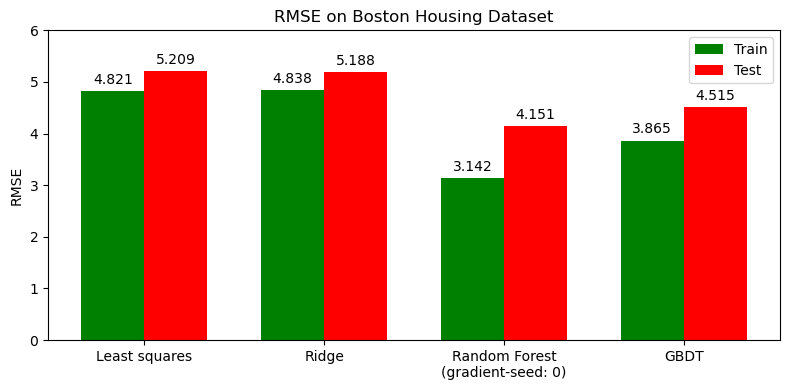

In [21]:

# Set the labels for the bar chart
alg_names = ['Least squares', 'Ridge', 'Random Forest\n(gradient-seed: 0)', 'GBDT\n']

# Round the training and test RMSE values to 3 decimal places
train_rmse = [np.round(x, 3) for x in [rmse_train_vanilla, rmse_train_r, train_rmse_RF_zeros, train_rmse_GBDT]]
test_rmse = [np.round(x, 3) for x in [rmse_test_vanilla, rmse_test_r, test_rmse_RF_zeros, test_rmse_GBDT]]

# Create an array of x-coordinates for the bar chart
x_pos = np.arange(len(alg_names))

# Set the colors for the bars
train_color = 'green'
test_color = 'red'

# Create a new figure with a specific size and DPI
fig, ax = plt.subplots(figsize=(8, 4), dpi=100)

# Set the width of the bars
bar_width = 0.35

# Create the bars for the training and test RMSE values
train_bars = ax.bar(x_pos - bar_width/2, train_rmse, width=bar_width, label='Train', color=train_color)
test_bars = ax.bar(x_pos + bar_width/2, test_rmse, width=bar_width, label='Test', color=test_color)

# Set the axis labels and title
ax.set_ylabel('RMSE')
ax.set_title('RMSE on Boston Housing Dataset')
ax.set_xticks(x_pos)
ax.set_xticklabels(alg_names)
ax.legend()

# Add labels to the bars
ax.bar_label(train_bars, padding=3)
ax.bar_label(test_bars, padding=3)

# Set the y-axis limits
ax.set_ylim((0, 6))

# Adjust the layout and display the figure
fig.tight_layout()
plt.show()

Credit-g dataset

In [22]:
# TODO: GBDT classification on credit-g dataset

# load data
from sklearn.datasets import fetch_openml
X, y = fetch_openml('credit-g', version=1, return_X_y=True, data_home='credit/')
y = np.array(list(map(lambda x: 1 if x == 'good' else 0, y)))

# train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)
#X_train = pd.get_dummies(X_train)
#X_test = pd.get_dummies(X_test)
print(type(X_train))   # should be numpy.ndarray
print(type(y_train))   # should be numpy.ndarray



<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


Breast cancer dataset

In [29]:
# TODO: GBDT classification on breast cancer dataset

# load data
from sklearn import datasets
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target

# train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)

In [32]:
rf = RF(loss='log', gradient_seed="zeros")
rf.fit(X_train, y_train)
train_pred = rf.predict(X_train)
train_acc_RF_zeros = accuracy(train_pred, y_train)
print("Train accuracy using Random Forest, zeros gradient-seed: ", train_acc_RF_zeros)
test_pred = rf.predict(X_test)
test_acc_RF_zeros = accuracy(test_pred, y_test)
print("Test accuracy using Random Forest, zeros gradient-seed: ", test_acc_RF_zeros)

Train accuracy using Random Forest, zeros gradient-seed:  0.992462311557789
Test accuracy using Random Forest, zeros gradient-seed:  0.9649122807017544


In [34]:
gbdt = GBDT(num_trees=15, gamma=1, min_sample_split=31, max_depth=8, loss="log")
gbdt.fit(X_train, y_train)
train_pred = gbdt.predict(X_train)
train_acc_GBDT = accuracy(train_pred, y_train)
print("Train accuracy using GBDT: ", train_acc_GBDT)
test_pred = gbdt.predict(X_test)
test_acc_GBDT = accuracy(test_pred, y_test)
print("Test accuracy using GBDT: ", test_acc_GBDT)

Train accuracy using GBDT:  0.9748743718592965
Test accuracy using GBDT:  0.9415204678362573
